# Introduction

The purpose of this post is to perform some exploratory data analysis on a very small data set provided by Kaggle.com. The project is a multiclass classification problem in which we try to classify different kinds of monsters (ghosts, ghouls, and goblins) based on various feature "measurements". This seemed like a nice little Halloween project to try out! We will compare four different classifiers in this work - logistic regression, k-nearest neighbors, support vector machines, and random forests.

# Exploring the Data

Let’s begin by importing the appropriate Python libraries and reading in the data.

In [232]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from scipy.stats import boxcox
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as mp
%matplotlib inline

df = pd.read_csv('/Users/degrave/DataScience/site/creatures/train.csv')

Let's summarize the data.

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


And we can examine the data in another way.

In [234]:
df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


The data contain measurements for 371 creatures in seven columns. There are four numerical columns (*bone_length*, *rotting_flesh*, *hair_length*, and *has_soul*) with all values falling in the range [0, 1], and one categorical column (*color*). It turns out that the creatures are not well separated by color. This feature actually adds noise to the problem and serves to decrease classification accuracy. To this end, we will simply drop the *color* column from our data set. We'll also drop the *id* column as well, as this provides no predictive information.

In [235]:
df.drop(['id','color'], axis=1, inplace=True)

The number of numerical columns is small enough that we can make use of Seaborn's nice *pairplot* function to quickly visualize the data.

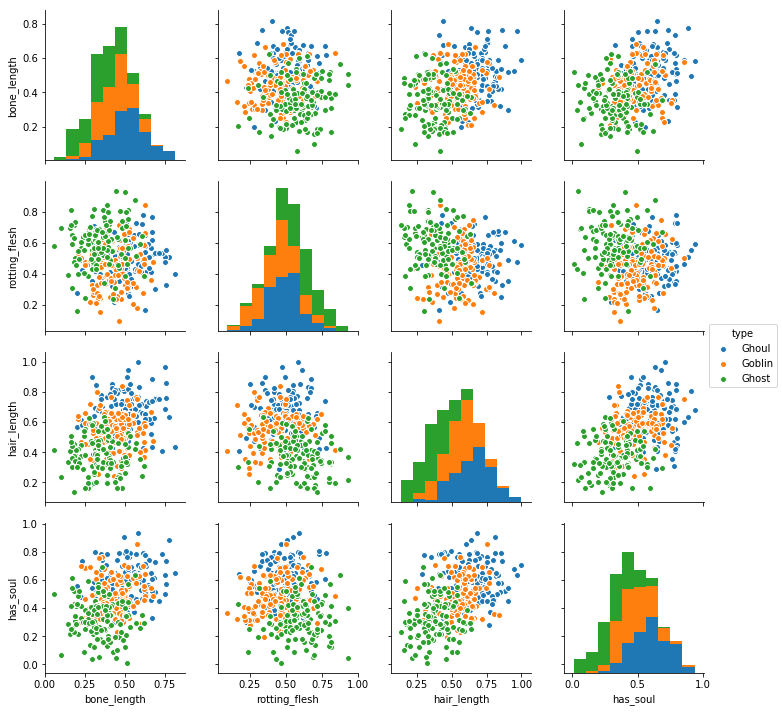

In [236]:
sns.pairplot(df, hue='type')

The pairplot function plots every numerical column against every other and separates the points in color by creature type (ghost, ghoul, or goblin), allowing us to quickly identify obvious trends in the data. Wherever a column is plotted against itself (e.g., along the diagonal), normalized histrograms are shown.

The figures show that the creatures are reasonably well-separated in some cases. For example, plotting *has_soul* vs. *hair_length* shows reasonably good distinction between the three creatures, while plotting *rotting_flesh* vs. *bone_length* results in poor separation. Let's plot the data another way.

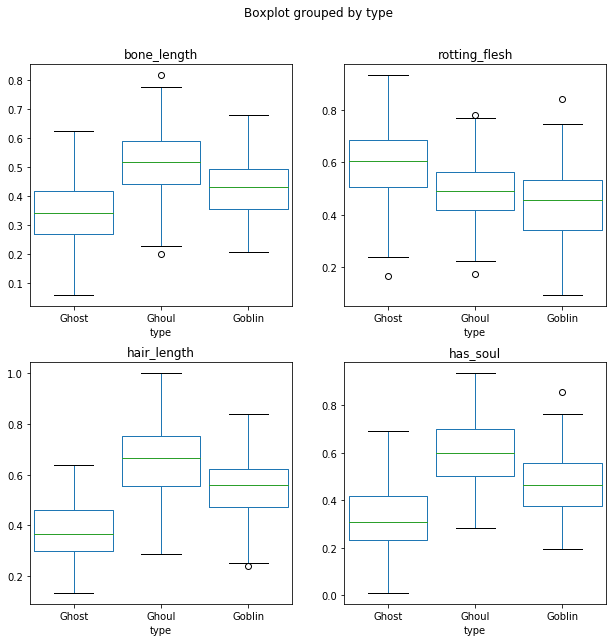

In [237]:
fig, axes = mp.subplots(nrows=2, ncols=2, figsize=(10,10))

mp.tight_layout(w_pad=5.0, h_pad=5.0)

ax = df.boxplot(by='type', column='bone_length', widths=(0.9, 0.9, 0.9), grid=False, ax=axes[0,0])
ax = df.boxplot(by='type', column='rotting_flesh', widths=(0.9, 0.9, 0.9), grid=False, ax=axes[0,1])
ax = df.boxplot(by='type', column='hair_length', widths=(0.9, 0.9, 0.9), grid=False, ax=axes[1,0])
ax = df.boxplot(by='type', column='has_soul', widths=(0.9, 0.9, 0.9), grid=False, ax=axes[1,1])

Again, there appears to be a clear distintion between the creature classes in each case. It is funny to think, though, that ghosts could have more rotting flesh (top right figure) than a goblin, and that a ghoul has longer hair (bottom left figure)! Let's see if the data columns are correlated.

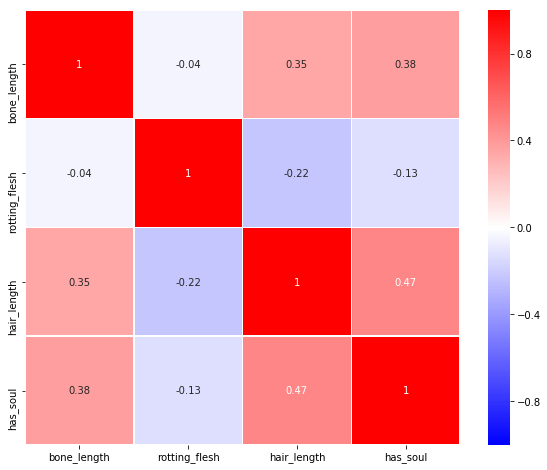

In [238]:
fig, axes = mp.subplots(figsize=(10,8))

sns.heatmap(np.round(df.corr(), 2), annot=True, cmap='bwr',
                vmin=-1, vmax=1, square=True, linewidths=0.5)

Looking at the off-diagonal values, it appears that there is some minor correlation between *has_soul* and *hair_length*. However, these correlation values are quite small and shouldn't really affect our models.

Since the creature types are in string format, we must first encode them before we start our classification. To do this we can use Scikit-Learn's LabelEncoder function.

In [239]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

df['type'] = enc.fit_transform(df['type'])

The histograms diplayed earlier show that the data are already fairly normally distributed. However, I'll run them through a Box-Cox transformer anyway just to be sure.

In [240]:
numerical = df.columns[df.dtypes == 'float']

for i in numerical:
    if df[i].min() > 0:
        transformed, lamb = boxcox(df.loc[df[i].notnull(), i])
        if (lamb < 1 - 0.02) | (lamb > 1 + 0.02):
            df.loc[df[i].notnull(), i] = transformed

Scikit-Learn's machine learning algorithms usually require features to take on similar ranges of values to yield good results. To this end, we use StandardScaler to scale the feature columns so that each has a mean of zero and unit standard deviation.

In [241]:
sc = StandardScaler()

numerical = df.columns[df.dtypes == 'float64'].tolist()

df[numerical] = sc.fit_transform(df[numerical])

# Classifying the Creatures

Okay, now we can do some classifying! To get thse most out of our classifiers, we must tune their various parameters to the problem at hand. Below, we loop over each classifier and optimize its parameters using GridSearchCV, saving the best five-fold cross-validation score of each classifier in the process.

In [242]:
X = df.drop('type', axis=1)
y = df['type']

In [243]:
params_LR = {'C': 10**np.linspace(-3,3,100)}
params_KN = {'n_neighbors': np.arange(1,30,1).astype(int)}
params_SV = {'C': 10**np.linspace(-3,3,100)}
params_RF = {'n_estimators': [10,25,50,75,100,200]}

models = [LogisticRegression(), KNeighborsClassifier(), SVC(kernel='rbf'), RandomForestClassifier()]
params = [params_LR, params_KN, params_SV, params_RF]

scores = []
for i, model in enumerate(models):
    grid = GridSearchCV(model, params[i], cv=5)
    grid.fit(X, y)
    scores.append(grid.best_score_)

Let's see how the classifiers performed.

In [244]:
scores

[0.7493261455525606,
 0.7520215633423181,
 0.7601078167115903,
 0.7250673854447439]

On average, the algorithms are able to correctly classify the creatures about 75% of the time, with the support vector classifer and k-nearest neighbors giving the best results.

# Principal Component Analysis

In certain real-world problems where the feature array is very large (e.g., many hundreds or thousands of columns), one can use a technique called principal component analysis (PCA) to reduce the dimensionality of the dataset. PCA is used to tranform the predictors to a new, smaller feature space that aims to explain the most variance in the data. This dimensionality reduction often serves to speed up the model parameter tuning and fitting procedures, and can sometimes help to remove noisy features from the data that are not useful in predicting the target. Though we only have four features in this example and it is not really necessary to do, we will carry out PCA here to see what kind of results we get.

Let's first perform PCA on our feature array to see how much variance can be explained by the various components.

(0, 1.01)

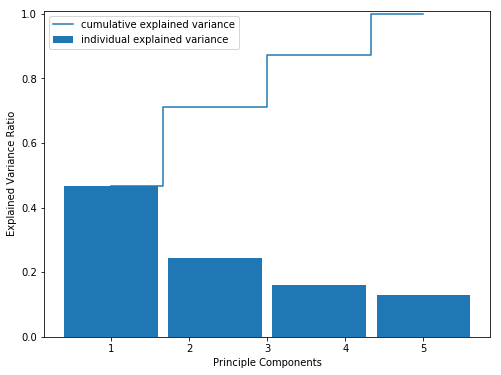

In [247]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X.shape[1])
pca.fit(X)

pca.explained_variance_ratio_
cum_var = np.cumsum(pca.explained_variance_ratio_)

fig, axes = mp.subplots(figsize=(8,6))

mp.bar(np.linspace(1,X.shape[1]+1,X.shape[1]), pca.explained_variance_ratio_, width=1.2, align='center', label='individual explained variance')
mp.step(np.linspace(1,X.shape[1]+1,X.shape[1]), cum_var, where='mid', label='cumulative explained variance')
mp.ylabel('Explained Variance Ratio')
mp.xlabel('Principle Components')
mp.legend(loc='best')
mp.ylim([0, 1.01])

The figure above suggests that a single principal component alone can explain almost 50% of the variance in the data. Remember, though, that these principal components are *not* the same as the original feature columns; in reality, they are actually *linear combinations* of the original columns. In real data science problems, it is sometimes the case that the first few components can describe the vast majority of the variance in the data, while the remaning tens, hundreds, or thousands of features are not relevant and can be discarded with little effect on the final classification results. The step function in the figure shows the cumulative sum of each principal component with the ones before it. In this example problem, three features are needed to explain about 90% of the variance.

Scikit-Learn's PCA function allows one to specify how many components to keep, with the maximum number of components being equal to the number of columns in the feature array. Let's loop through the maximum number of components (four) to see how the support vector classifier performs in each case.

In [248]:
scores = []
for i in range(1,X.shape[1]+1):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)

    params = {'C': 10**np.linspace(-3,3,100)}
    grid = GridSearchCV(SVC(kernel='rbf'), params, cv=5)
    grid.fit(X_pca, y)
    scores.append(grid.best_score_)

print(scores)

[0.7358490566037735, 0.7493261455525606, 0.7601078167115903, 0.7601078167115903]


The support vector classifier is able to reach its maximum performance with only three principal components.

# Comparing Decision Boundaries

Lastly, let's keep two principal components for plotting purposes, and see what the decision boundary looks like for the four classifiers used in this example.

In [249]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

params = {'C': 10**np.linspace(-3,3,100)}
grid = GridSearchCV(LogisticRegression(), params, cv=5)
pca_LR = grid.fit(X_pca, y)

params = {'n_neighbors': np.arange(1,30,1).astype(int)}
grid = GridSearchCV(KNeighborsClassifier(), params, cv=5)
pca_KN = grid.fit(X_pca, y)

params = {'C': 10**np.linspace(-3,3,100)}
grid = GridSearchCV(SVC(kernel='rbf'), params, cv=5)
pca_SV = grid.fit(X_pca, y)

params = {'n_estimators': [10,25,50,75,100,200]}
grid = GridSearchCV(RandomForestClassifier(), params, cv=5)
pca_RF = grid.fit(X_pca, y)

Below, we define a function to plot the principal component values for the three creature classes, as well as the decision boundary for each classifier.

In [250]:
def plot_decision_regions(X, y, classifier, resolution=0.2):
    from matplotlib.colors import ListedColormap
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    mp.contour(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    mp.xlim([xx1.min(), xx1.max()])
    mp.ylim([xx2.min(), xx2.max()])

    for idx, cl in enumerate(np.unique(y)):
        mp.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

Okay, let's see what the decision boundaries look like!

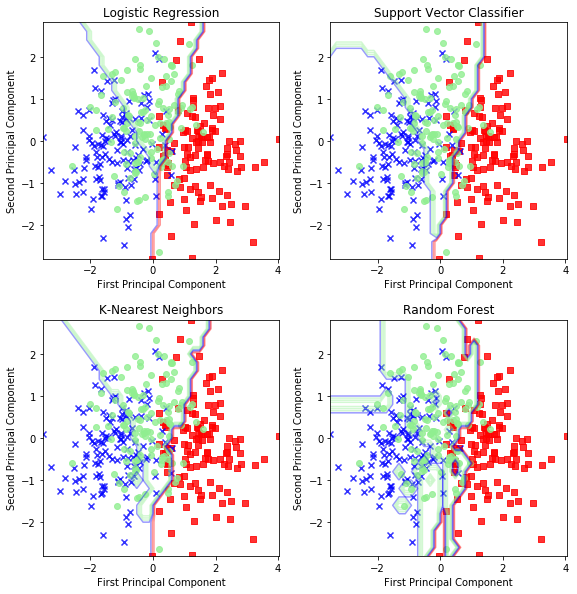

In [251]:
estimators = [pca_LR, pca_SV, pca_KN, pca_RF]
estimnames = ['Logistic Regression', 'Support Vector Classifier', 'K-Nearest Neighbors', 'Random Forest']

fig, axes = mp.subplots(nrows=2, ncols=2, figsize=(8,8))

mp.tight_layout(w_pad=2.0, h_pad=4.0)

for i in range(0,len(estimators)):
    mp.subplot(2,2,i+1)
    plot_decision_regions(X_pca, y, classifier=estimators[i], resolution=0.2)
    mp.xlabel('First Principal Component')
    mp.ylabel('Second Principal Component')
    mp.title(estimnames[i])
    mp.xlim([min(X_pca[:,0]),max(X_pca[:,0])])
    mp.ylim([min(X_pca[:,1]),max(X_pca[:,1])])

Using two principle components resuts in reasonably good separation of the classes - certainly better than many or most of the two-dimensional plots in the first figure at the top of this post. The decision boundaries for the logistic regression and k-nearest neighbors models are quite similar. They take on a "Y" shape with one class to the left (blue points), another to the right (red points), and the third isolated in the fork (green points). The support vector classifier boundaries exhibit a similar shape, but the left-most boundary is non-linear. The random forest model is highly non-linear, and this is mirrored in the model's decision boundaries. The poorer predictive performance of the model could be due to some overfitting. We an see that some of the boundaries are so flexible that they encompass only a few of the green points at a time.

Well, that's all for now. Thanks for following along!

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>